In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from typing import Tuple, List

#### TSM weekly code (ignore this hidden section if you already have weekly scores)

In [ ]:
def get_agent_durations(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """Calculates total duration per agent."""
    tmp = df[['agent', 'started_at', 'finished_at']].copy()
    tmp['started_at'] = pd.to_datetime(tmp['started_at'])
    tmp['finished_at'] = pd.to_datetime(tmp['finished_at'])
    
    # Calculate duration in minutes
    tmp['duration'] = ((tmp['finished_at'] - tmp['started_at']).dt.total_seconds() / 60.0).clip(lower=0)
    
    return tmp.groupby('agent')['duration'].sum().reset_index().rename(columns={'duration': col_name})



def append_df(df: pd.DataFrame, path: str):
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)



NUMERIC_COLS = [
    "unique_location_ids",
    "avg_distance_from_home_km",
    "avg_speed_kmh",
    "max_stay_duration",
    "transformations",
    "max_distance_from_home",
]

def scale_train_test(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    numeric_cols: List[str] = NUMERIC_COLS,
) -> Tuple[pd.DataFrame, pd.DataFrame, RobustScaler]:
    """
    Fit scaler on train numeric columns, apply to both train and test.

    Uses RobustScaler (median + IQR), which is safer for heavy-tailed
    mobility features and anomalies.

    Returns:
        scaled_train_df
        scaled_test_df
        fitted_scaler
    """
    missing = [c for c in numeric_cols if c not in train_df.columns]
    if missing:
        raise ValueError(f"Missing numeric columns in train: {missing}")

    train = train_df.copy()
    test = test_df.copy()

    scaler = RobustScaler(quantile_range=(25.0, 75.0))

    fit_df = train[numeric_cols]

    scaler.fit(fit_df)

    train[numeric_cols] = scaler.transform(train[numeric_cols])
    test[numeric_cols] = scaler.transform(test[numeric_cols])

    return train, test, scaler


def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
    """
    Compute anomaly score for agents present in this partition.
    Rule:
      For each test row, compare to all train rows with same (agent, day_type, time_segment),
      keep min score; then agent score = max over its test rows of these mins.
    """
    if test_p.empty:
        return pd.DataFrame(columns=["agent", "anomaly_score"])

    # weights pinned as plain floats
    alpha = 0.280890
    beta = 0.146024
    gamma = 0.146024
    delta = 0.203904
    a = 0.024093
    b = 0.331588
    c = 0.933864
    d = 0.928097
    e = -0.638238

    KEYS = ["agent", "day_type", "time_segment"]

    test_p = test_p.reset_index(drop=True)
    test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

    pairs = test_p.merge(train_p, on=KEYS, how="inner", suffixes=("_test", "_train"))

    if pairs.empty:
        out = test_p.groupby("agent", sort=False).size().reset_index()[["agent"]]
        out["anomaly_score"] = 0.0
        return out

    score_count = (pairs["unique_location_ids_test"] - pairs["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (pairs["avg_distance_from_home_km_test"] - pairs["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (pairs["avg_speed_kmh_test"] - pairs["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (pairs["max_stay_duration_test"] - pairs["max_stay_duration_train"]).abs().to_numpy()
    transformations = (pairs["transformations_test"] - pairs["transformations_train"]).abs().to_numpy()
    max_distance    = (pairs["max_distance_from_home_test"] - pairs["max_distance_from_home_train"]).abs().to_numpy()

    dom_changed = (
        pairs["dominent_poi_test"].astype(str).to_numpy() !=
        pairs["dominent_poi_train"].astype(str).to_numpy()
    ).astype(np.float32)

    t_loc = pairs["unique_locs_test"].to_list()
    r_loc = pairs["unique_locs_train"].to_list()
    new_locs = np.fromiter(
    (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
     for t, r in zip(t_loc, r_loc)),
    dtype=np.float32, 
    count=len(pairs))

    t_poi = pairs["poi_dict_test"].to_list()
    r_poi = pairs["poi_dict_train"].to_list()
    new_pois = np.fromiter(
    (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
     for t, r in zip(t_poi, r_poi)),
    dtype=np.float32, 
    count=len(pairs))

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dom_changed) +
        (e * new_pois)
    ).astype(np.float32)

    pairs["pair_score"] = total

    min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

    test_agents = test_p.set_index("test_row_id")["agent"]
    min_df = min_per_test.to_frame("min_score").join(test_agents, how="left")

    out = min_df.groupby("agent", sort=False)["min_score"].max().reset_index()
    out.rename(columns={"min_score": "anomaly_score"}, inplace=True)

    return out


# ---------------- PARTITION DRIVER ----------------

def score_weekly_partitioned(train, test,
                             out_path: str,
                             n_parts: int = 200):
    """
    n_parts=100 means ~1% per shard. Use 200/500 if merge still heavy.
    """
    if os.path.exists(out_path):
        os.remove(out_path)

    train["pid"] = (train["agent"].values % n_parts).astype(np.int16)
    test["pid"]  = (test["agent"].values  % n_parts).astype(np.int16)

    for pid in range(n_parts):
        train_p = train[train["pid"] == pid].drop(columns=["pid"])
        test_p  = test[test["pid"] == pid].drop(columns=["pid"])

        if test_p.empty:
            continue

        print(f"Partition {pid}/{n_parts-1}: train_rows={len(train_p):,} test_rows={len(test_p):,}")

        out = score_partition(train_p, test_p)
        append_df(out, out_path)

        del train_p, test_p, out
        gc.collect()

    print("Done. Saved:", out_path)

In [ ]:
# subset dataset - 10K data with all anomalies and randomly selected 10 agents
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/train_weekly/agent_bucket=0.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/test_weekly/agent_bucket=0.csv')
train_scaled, test_scaled, scaler = scale_train_test(train, test)
score_weekly_partitioned(train_scaled, test_scaled, '../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

In [ ]:
# --- Configuration to find simulation prescene difference (past vs present) ---
TRAIN_DIR = Path("../../data/trial5/2m/stop_past")
TEST_DIR  = Path("../../data/trial5/2m/stop_future")

def bucket_id_from_path(p: Path) -> int:
    return int(p.name.split("agent_bucket=")[1].split(".parquet")[0])

train_files = {bucket_id_from_path(p): p for p in TRAIN_DIR.glob("agent_bucket=*.parquet")}
test_files  = {bucket_id_from_path(p): p for p in TEST_DIR.glob("agent_bucket=*.parquet")}
common_buckets = sorted(set(train_files).intersection(test_files))

all_bucket_results = []

for b in common_buckets:
    print(f"Processing bucket {b}...")
    
    train_df = pd.read_parquet(train_files[b]).rename(columns={"user_id": "agent"})
    train_dur = get_agent_durations(train_df, "train_duration")

    test_df = pd.read_parquet(test_files[b]).rename(columns={"user_id": "agent"})
    test_dur = get_agent_durations(test_df, "test_duration")

    bucket_df = pd.merge(train_dur, test_dur, on='agent', how='outer').fillna(0)
    all_bucket_results.append(bucket_df)

final_df = pd.concat(all_bucket_results, ignore_index=True)
threshold = final_df['train_duration'].quantile(0.16)
final_df = final_df[final_df['train_duration'] > threshold]

output_path = "consolidated_agent_durations.parquet"
final_df.to_parquet(output_path)

print(f"\nSuccessfully saved {len(final_df)} agents to {output_path}")

### Results

In [3]:
#loading ground truth - concat all the ground truth anomalous agents to gt

gt1 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (1).csv')
gt2 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (2).csv')
gt3 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (3).csv')
gt4 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (4).csv')

gt = pd.concat([gt1, gt2, gt3, gt4]).drop_duplicates().reset_index(drop=True)

In [16]:
# loading residents (something we internally processed to find agents who show consistant resident behaviour in past and future)

res = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/Sim1_Trial5_Agent_Classification.csv', low_memory=False)
res = res[(res['past_classification'] == 'residents') & (res['future_classification'] == 'residents')]

# here we calculated the amount of hours of difference presence in the simulation past vs present (you can find the function hidden above that used to create this)
time_diff = pd.read_parquet('consolidated_agent_durations.parquet')
time_diff['difference'] = abs(time_diff['train_duration'] - time_diff['test_duration'])

# the created anomaly score dataset from tsm_weekly
anomaly_df = pd.read_csv('../../processed/trial5/2m/weekly_max.csv')

anomaly_df = anomaly_df[anomaly_df['agent'].isin(res['agent'].values)]
gt_anomaly_agents = set(gt['agent'].values)
anomaly_df['is_anomaly'] = 0
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

anomaly_df = anomaly_df.merge(time_diff[['agent', 'difference']], on='agent', how='left')
anomaly_df = anomaly_df.fillna(0)

# Attention: this step can be commented out -its just setting the time difference of past vs present less than 3000
anomaly_df = anomaly_df[anomaly_df['difference'] < 2900]

In [18]:
anomaly_df.sort_values(by = 'anomaly_score', ascending=False).head(60)

,agent,anomaly_score,is_anomaly,difference
1187711,1505192,25.646454,1,2617.833333
1288158,1633619,23.565681,1,2656.000000
77349,98000,23.394724,1,2139.500000
1187032,1505805,22.136126,1,2605.000000
5335,6277,21.077812,1,2773.500000
1513925,1919752,20.710554,1,2588.666667
164377,208723,20.225624,1,2515.833333
721411,914364,20.131226,1,2705.666667
880037,1115171,19.949490,1,2628.166667
1205574,1528154,19.804796,1,2777.166667


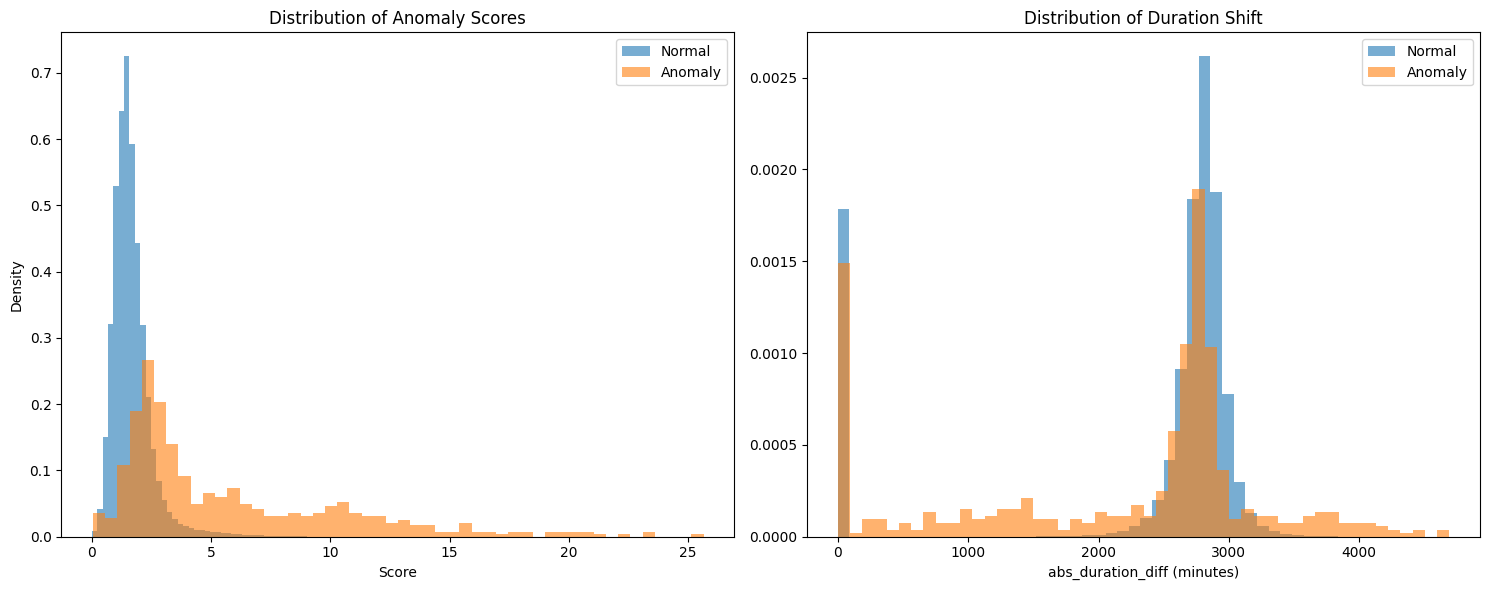

In [26]:
import matplotlib.pyplot as plt

# Data Prep
normal_scores  = anomaly_df[anomaly_df["is_anomaly"] == 0]["anomaly_score"]
anomaly_scores = anomaly_df[anomaly_df["is_anomaly"] == 1]["anomaly_score"]
diff_normal    = anomaly_df[anomaly_df["is_anomaly"] == 0]["difference"]
diff_anomaly   = anomaly_df[anomaly_df["is_anomaly"] == 1]["difference"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: Anomaly Scores
ax1.hist(normal_scores, bins=50, alpha=0.6, label="Normal", density=True)
ax1.hist(anomaly_scores, bins=50, alpha=0.6, label="Anomaly", density=True)
ax1.set_title("Distribution of Anomaly Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Density")
ax1.legend()

# # Right Plot: Duration Diff (Split by Label)
ax2.hist(diff_normal, bins=50, alpha=0.6, label="Normal", density=True)
ax2.hist(diff_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True)
ax2.set_title("Distribution of Duration Shift")
ax2.set_xlabel("abs_duration_diff (minutes)")
ax2.legend()

plt.tight_layout()
plt.show()

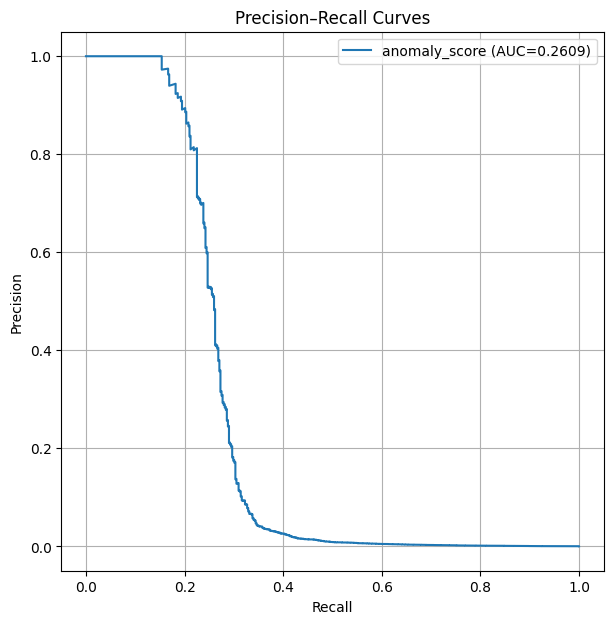

In [19]:
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()